# Gaussian Process Tutorial - Part 3: Application

In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import cm
from random import sample 
import pdb
import tensorflow as tf
import gpflow

sns.set_style('darkgrid')
np.random.seed(42)
#

# Regression

## Prediction 

In [2]:
# Load the data - measurements of head acceleration in a simulated motorcycle accident,
mcycle = pd.read_csv(
   "mcycle.csv", 
    dtype=np.float64,
    sep=";",
    decimal=","
)

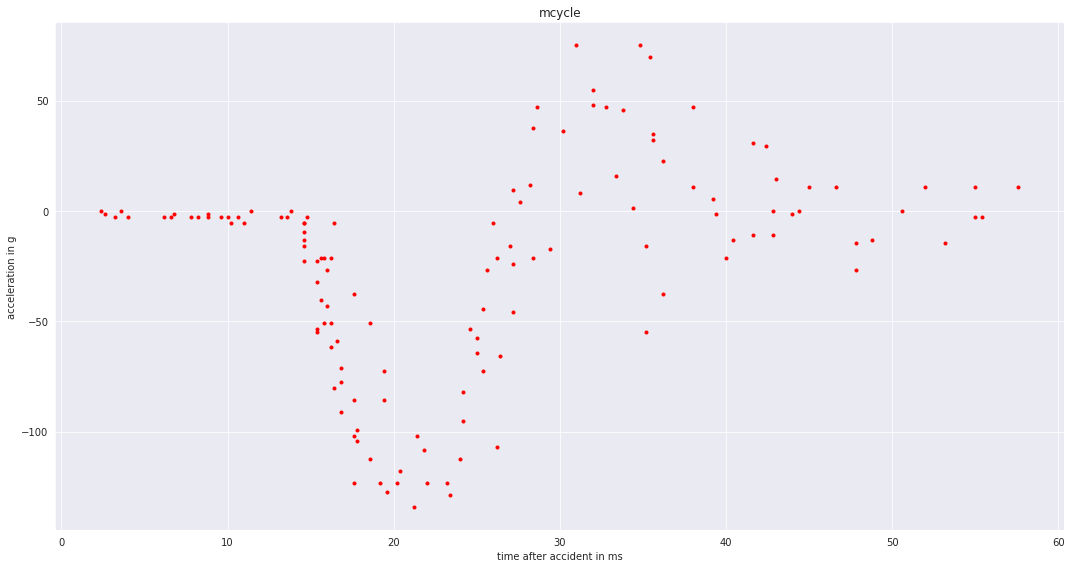

In [3]:
# plot
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(mcycle['times'],mcycle['accel'], 'r.')
ax1.set_title('mcycle')
ax1.set_xlabel('time after accident in ms')
ax1.set_ylabel('acceleration in g')

plt.tight_layout()
plt.show()

In [4]:
X_train = mcycle.loc[:,"times"].ravel().reshape((-1,1))
y_train = mcycle.loc[:,"accel"].ravel().reshape((-1,1))
X_test = np.linspace(0, 70, num=800).reshape((-1,1))

In [5]:
# length_scale = 5.25, sigma = 2025, noise_var = 256
kernel = gpflow.kernels.SquaredExponential(variance=1., lengthscale=1.)
model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel)

In [6]:
gpflow.utilities.print_summary(model)

name                     class      transform    trainable    shape    dtype      value
-----------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64        1
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64        1
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64        1


In [7]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))


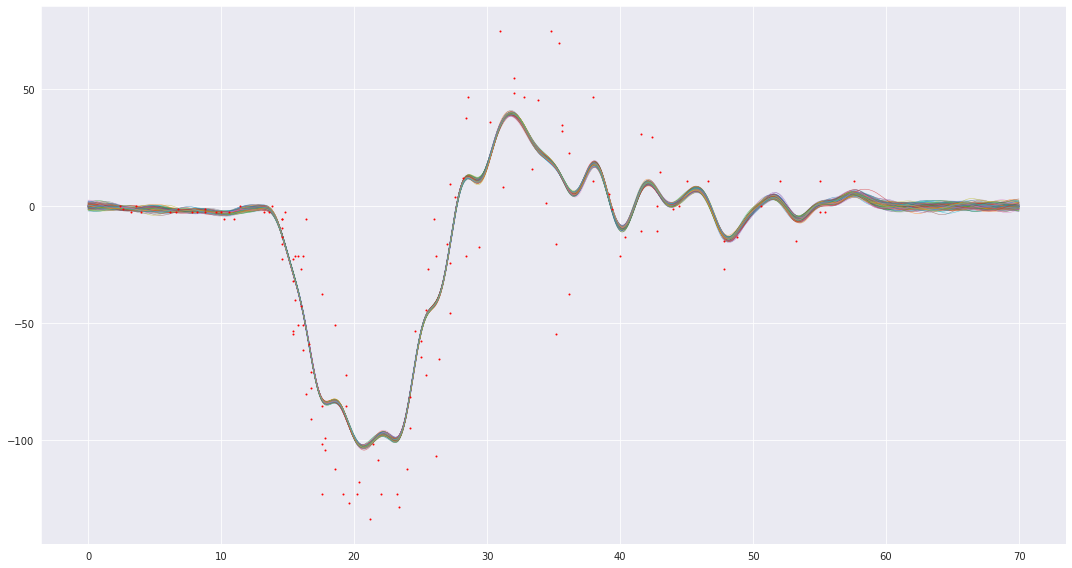

In [8]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
if f_star_samples is not None:
    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=.7)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.tight_layout()
plt.show()
#

In [9]:
opt = gpflow.optimizers.Scipy()

In [10]:
def objective_closure():
    return - model.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=2000))

In [11]:
gpflow.utilities.print_summary(model)

name                     class      transform    trainable    shape    dtype        value
-----------------------  ---------  -----------  -----------  -------  -------  ---------
GPR.kernel.variance      Parameter  Softplus     True         ()       float64  2046.71
GPR.kernel.lengthscale   Parameter  Softplus     True         ()       float64     5.2405
GPR.likelihood.variance  Parameter  Softplus     True         ()       float64   508.637


In [12]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))


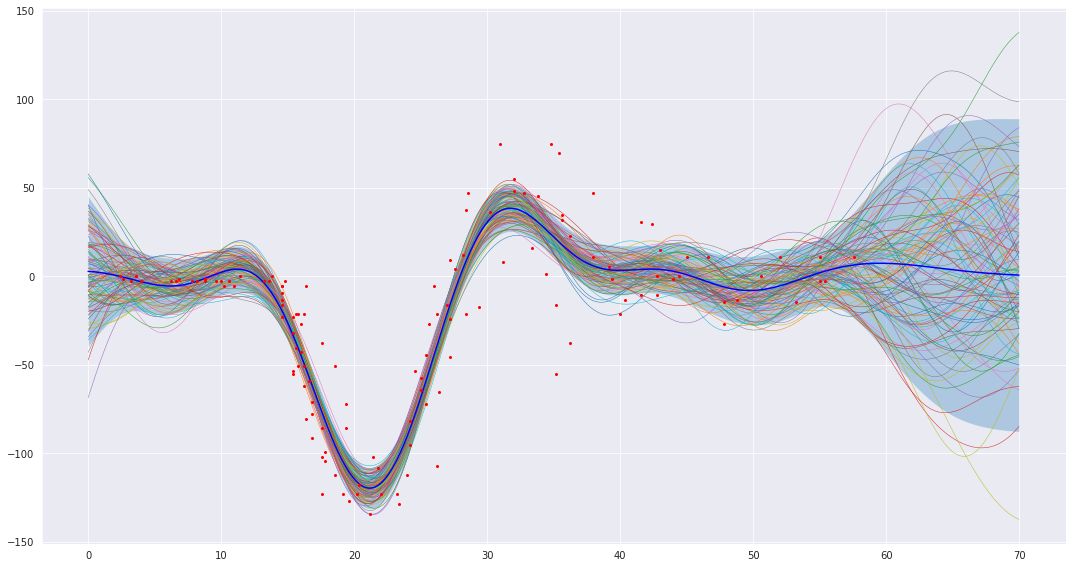

In [13]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))


if f_star_samples is not None:
    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), '-', ms=3, lw=.5, alpha=1)
ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=4)

plt.tight_layout()
plt.show()
#

## Forecasting

### Structured Modeling



#### Air Passenger

In [14]:
# Load the data
df = pd.read_csv(    
    'AirPassengers.csv',
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    dtype=np.float64
)
df.head()

,value
index,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [15]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='index', length=144, freq=None)

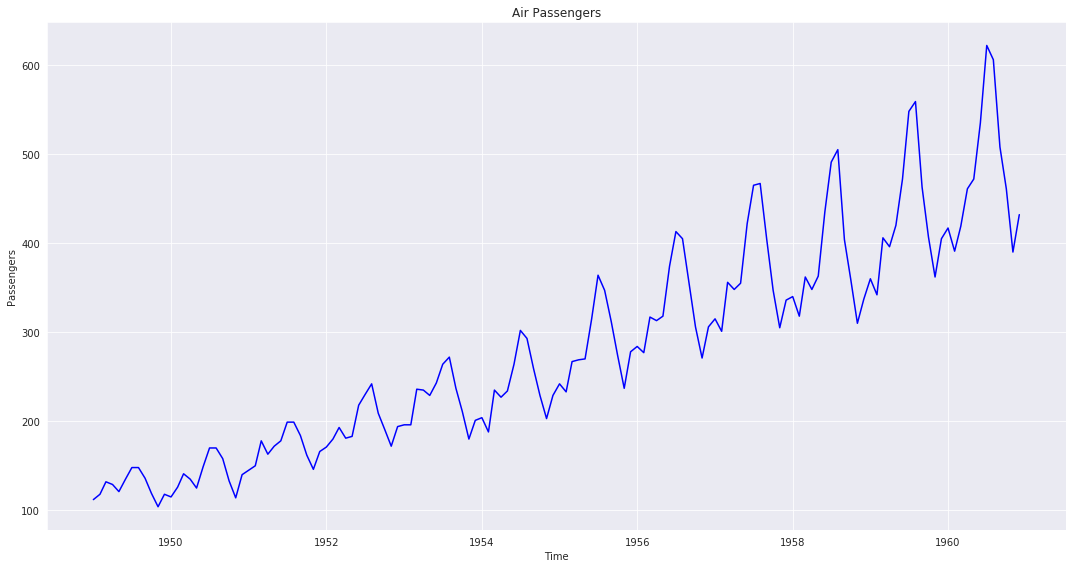

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# plot
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(df.index, df['value'], 'b-')
ax1.set_title('Air Passengers')
ax1.set_xlabel('Time')
ax1.set_ylabel('Passengers')

plt.tight_layout()
plt.show()

In [17]:
X_train = np.arange(0, df.shape[0], dtype=np.float64).reshape((-1,1))
y_train = df.value.ravel().reshape((-1,1))
X_test = np.arange(0, df.shape[0]+24, dtype=np.float64).reshape((-1,1))

In [18]:
k1 = gpflow.kernels.SquaredExponential(variance=66., lengthscale=67.)
k2 = gpflow.kernels.SquaredExponential() * gpflow.kernels.Periodic(period=12) # (sigma=2.4, length_scale=90), Periodic(length_scale=1.0, period=1.3))
k3 = gpflow.kernels.RationalQuadratic() # (sigma=0.66, length_scale=1.2, alpha=0.78)
k4 = gpflow.kernels.SquaredExponential() * gpflow.kernels.White() # (sigma=0.18, length_scale=1.6), WhiteNoise(0.19))
kernel = k1 + k2 + k3 + k4

model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel)

In [19]:
gpflow.utilities.print_summary(model)

name                                          class      transform    trainable    shape    dtype      value
--------------------------------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.kernels[0].variance                Parameter  Softplus     True         ()       float64       66
GPR.kernel.kernels[0].lengthscale             Parameter  Softplus     True         ()       float64       67
GPR.kernel.kernels[1].kernels[0].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[0].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].period       Parameter  Softplus     True         ()       float64       12
GPR.kernel.kernels[

In [20]:
#model.kernel.kernels[0].variance.assign(1)
#model.kernel.kernels[0].lengthscale.assign(1)
#model.kernel.kernels[1].variance.assign(1)

In [21]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))


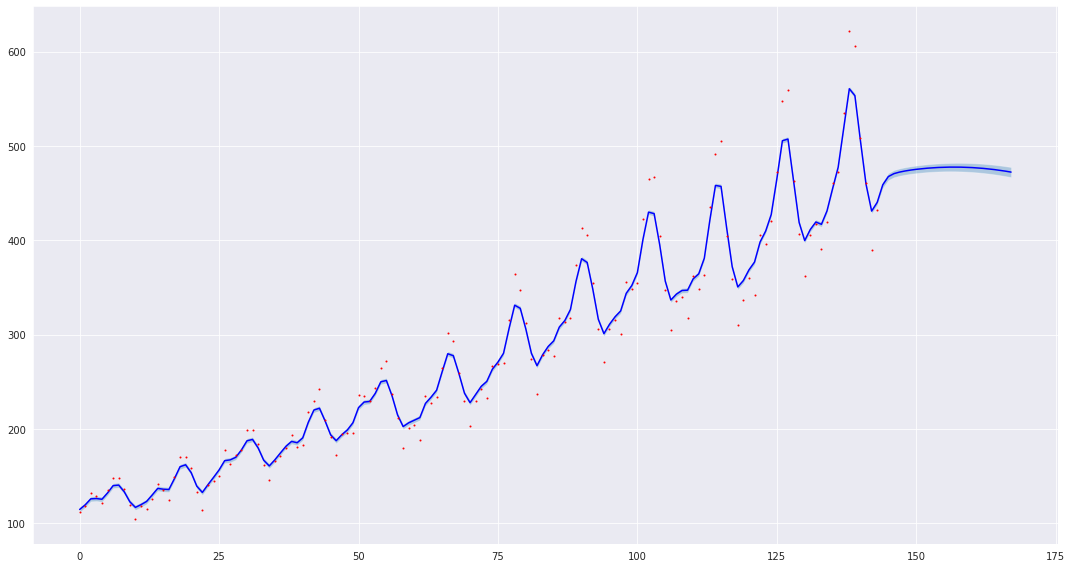

In [22]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=.3)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.tight_layout()
plt.show()
#

In [23]:
opt = gpflow.optimizers.Scipy()

In [24]:
def objective_closure():
    return - model.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=1000))

In [25]:
gpflow.utilities.print_summary(model)

name                                          class      transform    trainable    shape    dtype            value
--------------------------------------------  ---------  -----------  -----------  -------  -------  -------------
GPR.kernel.kernels[0].variance                Parameter  Softplus     True         ()       float64  234.693
GPR.kernel.kernels[0].lengthscale             Parameter  Softplus     True         ()       float64  124.649
GPR.kernel.kernels[1].kernels[0].variance     Parameter  Softplus     True         ()       float64  372.452
GPR.kernel.kernels[1].kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  225.533
GPR.kernel.kernels[1].kernels[1].variance     Parameter  Softplus     True         ()       float64  372.452
GPR.kernel.kernels[1].kernels[1].lengthscale  Parameter  Softplus     True         ()       float64    0.670626
GPR.kernel.kernels[1].kernels[1].period       Parameter  Softplus     True         ()       float64   12.0302
GPR

In [26]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))

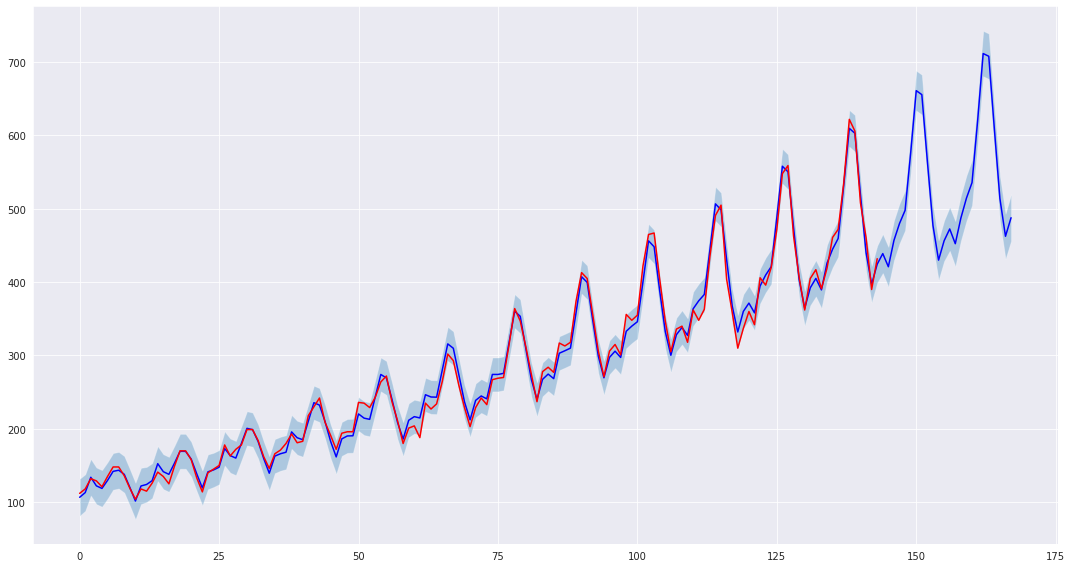

In [27]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=1)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r-', ms=4)

plt.tight_layout()
plt.show()
#

#### Mauna Loa $CO_2$

In [28]:
# Load the data
df = pd.read_csv(    
    'monthly_in_situ_co2_mlo.csv', 
    header=54, 
    skiprows=[55, 56], 
    usecols=[3, 4], 
    na_values='-99.99',
    dtype=np.float64
)

# Drop missing values
df.dropna(inplace=True)
# Remove whitespace from column names
df.rename(columns=lambda x: x.strip(), inplace=True)
#

In [29]:
df.head()

,Date,CO2
2,1958.2027,315.70
3,1958.2877,317.45
4,1958.3699,317.51
6,1958.5370,315.86
7,1958.6219,314.93


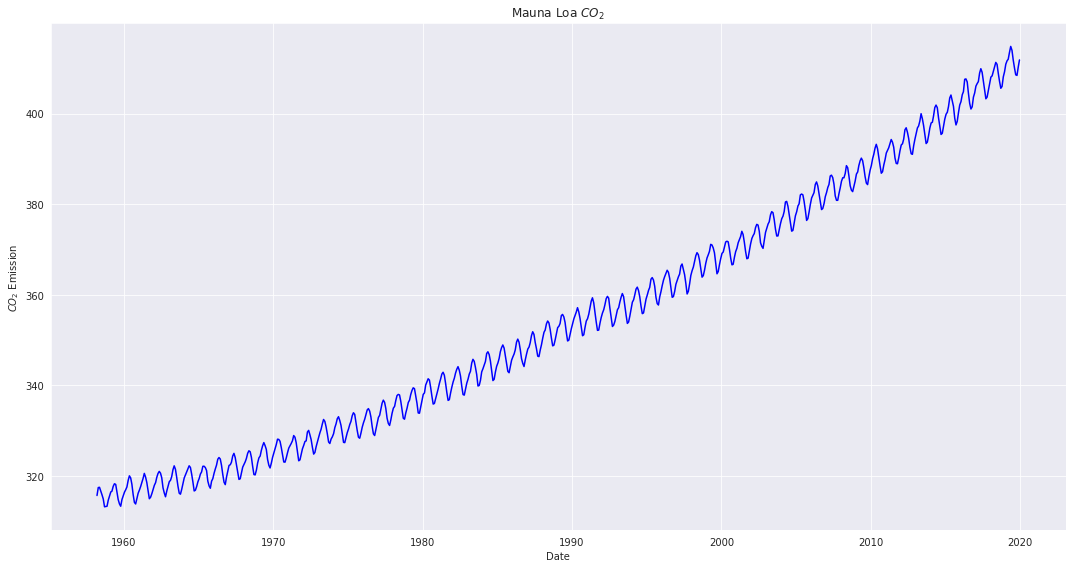

In [30]:
# plot
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.plot(df['Date'], df['CO2'], 'b-')
ax1.set_title('Mauna Loa $CO_{2}$')
ax1.set_xlabel('Date')
ax1.set_ylabel('$CO_2$ Emission')

plt.tight_layout()
plt.show()

In [31]:
X_train = df.loc[:,"Date"].ravel().reshape((-1,1))
y_train = df.loc[:,"CO2"].ravel().reshape((-1,1))
X_test = np.linspace(1959, 2030, num=852).reshape((-1,1))

In [32]:
# Source C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning
k1 = gpflow.kernels.SquaredExponential(variance=66., lengthscale=67.)
k2 = gpflow.kernels.SquaredExponential() * gpflow.kernels.Periodic() # (sigma=2.4, length_scale=90), Periodic(length_scale=1.0, period=1.3))
k3 = gpflow.kernels.RationalQuadratic() # (sigma=0.66, length_scale=1.2, alpha=0.78)
k4 = gpflow.kernels.SquaredExponential() * gpflow.kernels.White() # (sigma=0.18, length_scale=1.6), WhiteNoise(0.19))
kernel = k1 + k2 + k3 + k4

model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel)

In [33]:
gpflow.utilities.print_summary(model)

name                                          class      transform    trainable    shape    dtype      value
--------------------------------------------  ---------  -----------  -----------  -------  -------  -------
GPR.kernel.kernels[0].variance                Parameter  Softplus     True         ()       float64       66
GPR.kernel.kernels[0].lengthscale             Parameter  Softplus     True         ()       float64       67
GPR.kernel.kernels[1].kernels[0].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[0].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].variance     Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].lengthscale  Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[1].kernels[1].period       Parameter  Softplus     True         ()       float64        1
GPR.kernel.kernels[

In [34]:
#model.kernel.kernels[0].variance.assign(1)
#model.kernel.kernels[0].lengthscale.assign(1)
#model.kernel.kernels[1].variance.assign(1)

In [35]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))


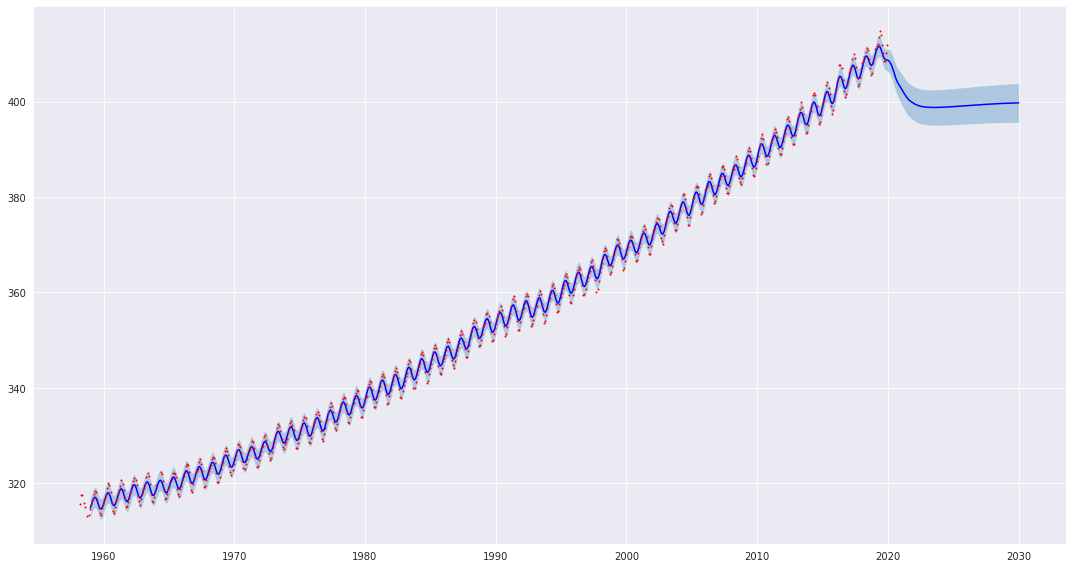

In [36]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=.3)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=2)

plt.tight_layout()
plt.show()
#

In [37]:
opt = gpflow.optimizers.Scipy()

In [38]:
def objective_closure():
    return - model.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        model.trainable_variables,
                        options=dict(maxiter=1000))

In [39]:
gpflow.utilities.print_summary(model)

name                                          class      transform    trainable    shape    dtype            value
--------------------------------------------  ---------  -----------  -----------  -------  -------  -------------
GPR.kernel.kernels[0].variance                Parameter  Softplus     True         ()       float64  104.97
GPR.kernel.kernels[0].lengthscale             Parameter  Softplus     True         ()       float64   73.8174
GPR.kernel.kernels[1].kernels[0].variance     Parameter  Softplus     True         ()       float64  172.207
GPR.kernel.kernels[1].kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  212.17
GPR.kernel.kernels[1].kernels[1].variance     Parameter  Softplus     True         ()       float64  172.207
GPR.kernel.kernels[1].kernels[1].lengthscale  Parameter  Softplus     True         ()       float64    2.3464
GPR.kernel.kernels[1].kernels[1].period       Parameter  Softplus     True         ()       float64    0.999984
GPR.

In [40]:
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))

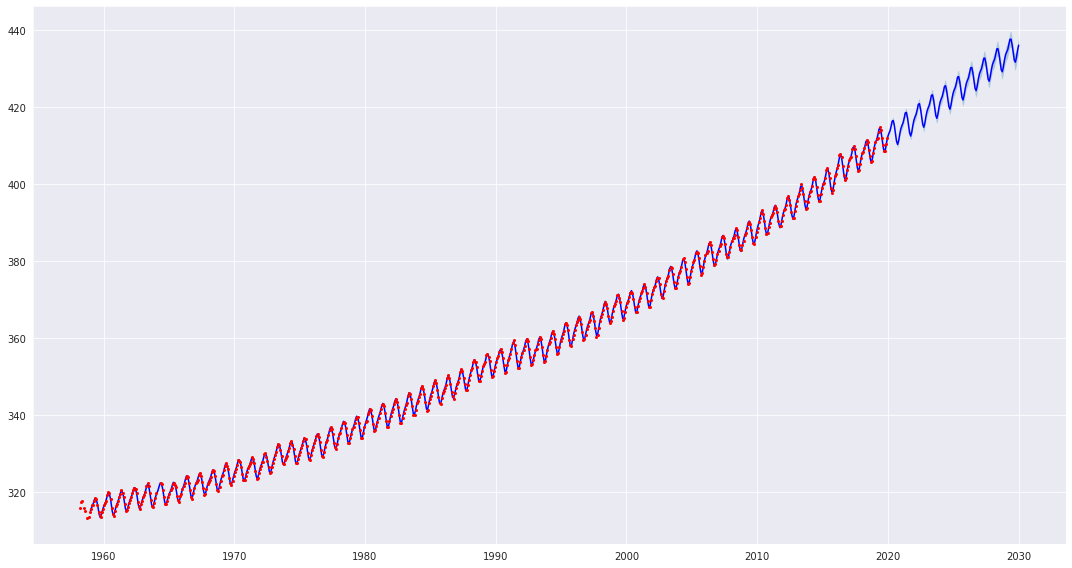

In [41]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=1)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train, y_train, 'r.', ms=4)

plt.tight_layout()
plt.show()
#

In [42]:
X_test = np.linspace(2000, 2030, num=30*12).reshape((-1,1))
f_star_mean, f_star_covar = model.predict_f(X_test)
f_star_samples = tf.squeeze(model.predict_f_samples(X_test, 100))

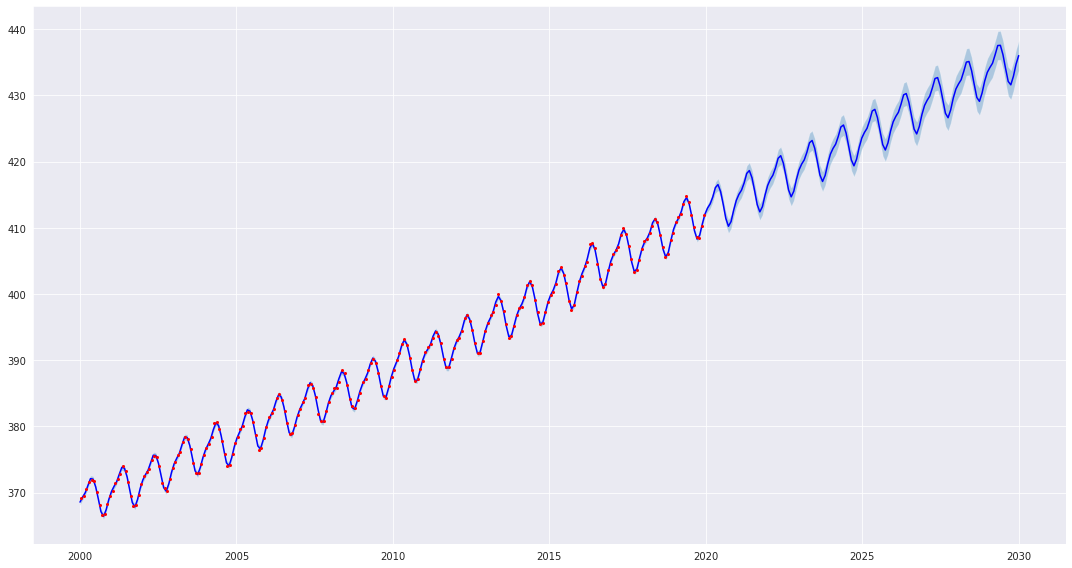

In [43]:
pointwise_variances = tf.squeeze(tf.linalg.diag(f_star_covar))
error = 1.96 * np.sqrt(pointwise_variances)

# plot
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(X_test.ravel(), tf.squeeze(f_star_mean), 'b' )
#if f_star_samples is not None:
#    ax.plot(X_test.ravel(), tf.transpose(f_star_samples), ms=2, lw=.5, alpha=1)
ax.fill_between(X_test.ravel(),  tf.squeeze(f_star_mean) - error,  tf.squeeze(f_star_mean) + error, alpha=0.3)
ax.plot(X_train[X_train>2000], y_train[X_train>2000], 'r.', ms=4)

plt.tight_layout()
plt.show()
#

### Regression

# Classification